# Delay model and parameter inference for Bheda et al.

We try to find parameters for a simple stochastic delay model that describe the data for WT and the Elp6 mutatnt strain. 

Let's first import pyabc (a great package for likelihood-free parameter estimation https://pyabc.readthedocs.io/en/latest/index.html)and other necessary packages.

## Imports

In [1]:
import pyabc
from pyabc import ABCSMC, Distribution, RV
import datetime
import pandas as pd
import numpy as np
import scipy as sp
import scipy.stats as st
import tempfile
import os
import seaborn as sns
import matplotlib.pyplot as plt
import random
from pyabc import (ABCSMC,
                   RV, Distribution,
                   MedianEpsilon,
                   LocalTransition)
import scipy as sp

## Data

We read in the data that is plotted in Fig. 4 in the manuscript

In [2]:
r1=pd.read_excel("delays_RD.xlsx")
r1.head()

,WT M2 Delay,elp6 M2 Delay,WT M2D2 RD,elp6 M2D2 RD
0,12.0,15.0,0.454545,0.000000
1,105.0,24.0,0.076923,0.040000
2,18.0,9.0,0.591837,0.310345
3,24.0,18.0,0.373134,0.452055
4,12.0,9.0,0.363636,0.200000


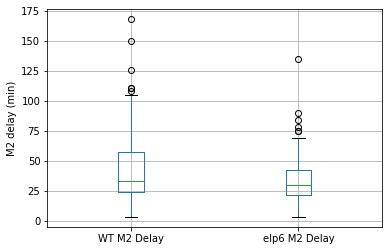

In [5]:
box1=r1.boxplot(column=['WT M2 Delay','elp6 M2 Delay'])
box1.set_ylabel('M2 delay (min)')
plt.show()

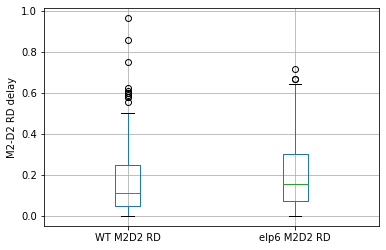

In [6]:
box1=r1.boxplot(column=['WT M2D2 RD','elp6 M2D2 RD'])
box1.set_ylabel('M2-D2 RD delay')
plt.show()

In [7]:
r2=r1.values

In [8]:
r2.shape 

(272, 4)

In [9]:
# define data here
s1=r2[:,0]
s2=r2[:,1]
s3=r2[:,2]
s4=r2[:,3]

data={'delays_WT': s1[~np.isnan(s1)], 'delays_E6': s2[~np.isnan(s2)], 'reldifs_WT': s3[~np.isnan(s3)], 'reldifs_E6': s4[~np.isnan(s4)]}

we determine the number of values for WT and Elp6

In [10]:
nVec= {'delays_WT': data['delays_WT'].shape[0], 
       'delays_E6': data['delays_E6'].shape[0], 
       'reldifs_WT': data['reldifs_WT'].shape[0], 
       'reldifs_E6': data['reldifs_E6'].shape[0]
      }

In [11]:
nVec

{'delays_WT': 161, 'delays_E6': 121, 'reldifs_WT': 272, 'reldifs_E6': 245}

## Delay model definition

we model the delays with a Gamma distribution, once for WT, once for Elp6. 
The Gamma distribution has two parameters: shape and scale.
(If shape is a natural number, the Gamma distribution is called an Erlang distribution.)
Thus, our model has four parameters: two for WT, two for Elp6. 

In [12]:
def model(parameter):
    # delays: simple, draw from gamma
    delaysWT = np.random.gamma(parameter['shape_WT'], parameter['scale_WT'], nVec['delays_WT'])
    delaysE6 = np.random.gamma(parameter['shape_E6'], parameter['scale_E6'], nVec['delays_E6'])
    
    # relative difference WT: draw mother M2 and daughter D2 and calc rel difference
    differencesWT = np.random.randn(nVec['reldifs_WT']) ## initialize vector
    for x in np.nditer(differencesWT,op_flags=['readwrite']):
        M2=np.random.gamma(parameter['shape_WT'],parameter['scale_WT'], 1)
        D2=np.random.gamma(parameter['shape_WT'],parameter['scale_WT'], 1)
        x[...]= abs(M2 - D2)/np.mean(np.concatenate([M2, D2]))
        
    # relative difference: draw mother M2 and daughter D2 and calc rel difference
    differencesE6 = np.random.randn(nVec['reldifs_E6']) ## initialize vector
    for x in np.nditer(differencesE6,op_flags=['readwrite']):
        M2=np.random.gamma(parameter['shape_E6'],parameter['scale_E6'], 1)
        D2=np.random.gamma(parameter['shape_E6'],parameter['scale_E6'], 1)
        x[...]= abs(M2 - D2)/np.mean(np.concatenate([M2, D2]))
        

    return {'delays_WT': delaysWT, 'delays_E6': delaysE6, 'reldifs_WT': differencesWT, 'reldifs_E6': differencesE6}
model

<function __main__.model(parameter)>

We define the prior to be the same for WT and Elp6

In [13]:
shapeMin=1;
shapeMax=20;
scaleMin=.1;
scaleMax=15.;

prior = Distribution(
    shape_WT = RV("uniform", shapeMin, shapeMax), 
    scale_WT = RV("uniform", scaleMin, scaleMax),
    shape_E6 = RV("uniform", shapeMin, shapeMax),
    scale_E6 = RV("uniform", scaleMin, scaleMax))
prior

<Distribution 'scale_E6', 'scale_WT', 'shape_E6', 'shape_WT'>

## Parameter fitting with pyABC

pyABC (https://pyabc.readthedocs.io/en/latest/index.html) is a great method to fit parameters without having to specify the likelihood function. All you need is a distance function between data and model that is minimized. We define our distance fuction as follows, normalizing terms to push them on the same order of magnitude and thus weight them equally during optimization.

In [19]:
def distance(sim, dat): 
    d1 = sp.absolute((sp.mean(sim['delays_WT'])-sp.mean(dat['delays_WT']))/sp.mean(dat['delays_WT']))
    d2 = sp.absolute((sp.var(sim['delays_WT'])-sp.var(dat['delays_WT']))/sp.var(dat['delays_WT']))
    d3 = sp.absolute((sp.mean(sim['reldifs_WT'])-sp.mean(dat['reldifs_WT']))/sp.var(dat['reldifs_WT'])/sp.sqrt(nVec['reldifs_WT']))
    d4 = sp.absolute((sp.var(sim['reldifs_WT'])-sp.var(dat['reldifs_WT']))/sp.sqrt(nVec['reldifs_WT']))
    
    e1 = sp.absolute((sp.mean(sim['delays_E6'])-sp.mean(dat['delays_E6']))/sp.mean(dat['delays_E6']))
    e2 = sp.absolute((sp.var(sim['delays_E6'])-sp.var(dat['delays_E6']))/sp.var(dat['delays_E6']))
    e3 = sp.absolute((sp.mean(sim['reldifs_E6'])-sp.mean(dat['reldifs_E6']))/sp.var(dat['reldifs_E6'])/sp.sqrt(nVec['reldifs_E6']))
    e4 = sp.absolute((sp.var(sim['reldifs_E6'])-sp.var(dat['reldifs_E6']))/sp.sqrt(nVec['reldifs_E6']))
    
    return d1+d2+d3+d4+e1+e2+e3+e4

Let's first reload a previous run of pyABC and inspect the parameters

In [28]:
abc_previous=ABCSMC(model, prior, distance)

download the file pyABCP_run.db from here (https://www.dropbox.com/s/e6cniaa1ihqfor1/pyABC_run.db?dl=0), put it in your current directory and adapt 'YOUR_PATH' below to that locations

In [29]:
run_id=5
db="sqlite:////YOUR_PATH/pyABC_run.db"
abc_previous.load(db, run_id)

5

In [33]:
abc_previous

In [39]:
history=abc_previous.history

### Analysis

Now let's look into the parameter posteriors

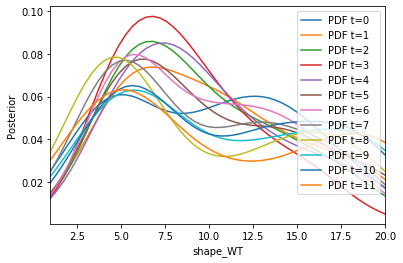

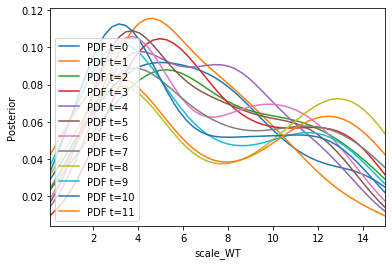

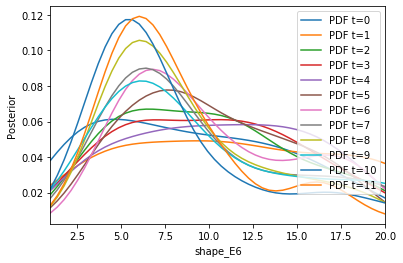

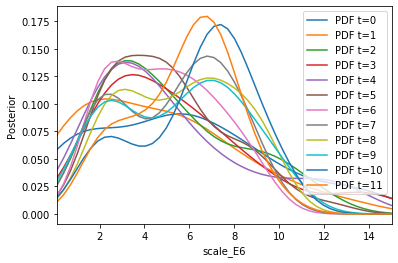

In [38]:
fig, ax = plt.subplots()
for t in range(history.max_t+1):
    df, w = history.get_distribution(m=0, t=t)
    pyabc.visualization.plot_kde_1d(
        df, w,
        xmin=shapeMin, xmax=shapeMax,
        x="shape_WT", ax=ax,
        label="PDF t={}".format(t))
ax.legend();

fig, ax = plt.subplots()
for t in range(history.max_t+1):
    df, w = history.get_distribution(m=0, t=t)
    pyabc.visualization.plot_kde_1d(
        df, w,
        xmin=scaleMin, xmax=scaleMax,
        x="scale_WT", ax=ax,
        label="PDF t={}".format(t))
ax.legend();

fig, ax = plt.subplots()
for t in range(history.max_t+1):
    df, w = history.get_distribution(m=0, t=t)
    pyabc.visualization.plot_kde_1d(
        df, w,
        xmin=shapeMin, xmax=shapeMax,
        x="shape_E6", ax=ax,
        label="PDF t={}".format(t))
ax.legend();

fig, ax = plt.subplots()
for t in range(history.max_t+1):
    df, w = history.get_distribution(m=0, t=t)
    pyabc.visualization.plot_kde_1d(
        df, w,
        xmin=scaleMin, xmax=scaleMax,
        x="scale_E6", ax=ax,
        label="PDF t={}".format(t))
ax.legend();
plt.show()

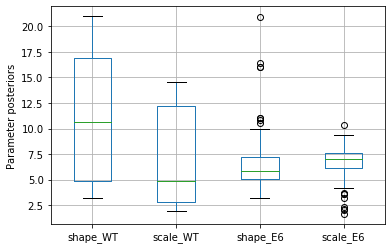

name
scale_E6     6.967313
scale_WT     4.822824
shape_E6     5.869406
shape_WT    10.626658
dtype: float64

In [42]:
bdf.boxplot(column=['shape_WT','scale_WT','shape_E6','scale_E6'])
box1.set_ylabel('Parameter posteriors')
plt.show()
df.median()

We find that while the scale is similar, the shape is estimated smaller for Elp6

### Model interpretation

Lets now use an Erlang distriubtion for the delay. For this, we simply make the shape parameter  a natural number (10 for WT, 6 for elp6) and keep the scale parameter the same for WT and elp6:

In [43]:
myParams=pd.DataFrame({"shape_WT": [10.],"scale_WT": [5.], 'shape_E6': [6.], 'scale_E6': [5.]})
myParams

,shape_WT,scale_WT,shape_E6,scale_E6
0,10.0,5.0,6.0,5.0


Let's see if the model can explain the data

In [44]:
sim=model(myParams)

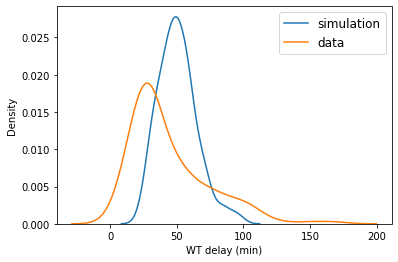

In [57]:
sns.distplot(sim['delays_WT'],hist=False,kde=True,label="simulation")
sns.distplot(data['delays_WT'],hist=False,kde=True,label="data")
plt.legend(prop={'size': 12})
plt.xlabel('WT delay (min)')
plt.ylabel('Density') 
plt.show()

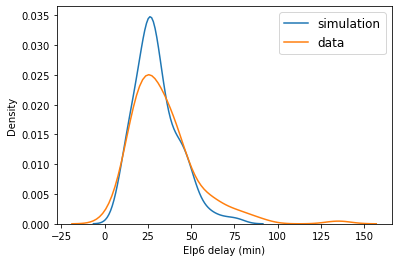

In [58]:
sns.distplot(sim['delays_E6'],hist=False,kde=True,label="simulation")
sns.distplot(data['delays_E6'],hist=False,kde=True,label="data")
plt.legend(prop={'size': 12})
plt.xlabel('Elp6 delay (min)')
plt.ylabel('Density') 
plt.show()

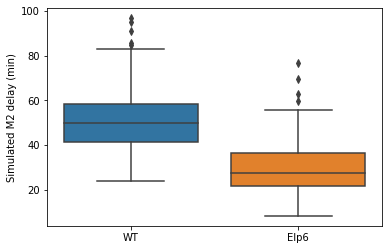

In [59]:
plot=sns.boxplot(data=[sim['delays_WT'], sim['delays_E6']])
plot.set_ylabel('Simulated M2 delay (min)')
plot.set_xticklabels(['WT','Elp6'])
fig=plot.get_figure()
plt.show()

In [47]:
fig.savefig("delays.pdf")

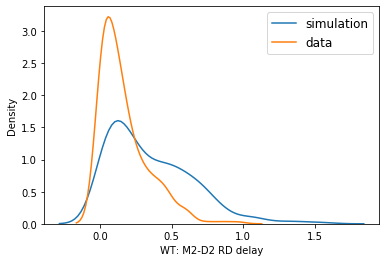

In [66]:
sns.distplot(sim['reldifs_WT'],hist=False,kde=True,label="simulation")
sns.distplot(data['reldifs_WT'],hist=False,kde=True,label="data")
plt.legend(prop={'size': 12})
plt.xlabel('WT: M2-D2 RD delay')
plt.ylabel('Density') 
plt.show()

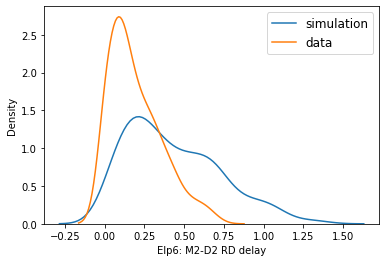

In [65]:
sns.distplot(sim['reldifs_E6'],hist=False,kde=True,label="simulation")
sns.distplot(data['reldifs_E6'],hist=False,kde=True,label="data")
plt.legend(prop={'size': 12})
plt.xlabel('Elp6: M2-D2 RD delay')
plt.ylabel('Density') 
plt.show()

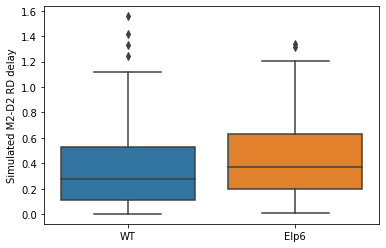

In [64]:
plot=sns.boxplot(data=[sim['reldifs_WT'], sim['reldifs_E6']])
plot.set_ylabel('Simulated M2-D2 RD delay')
plot.set_xticklabels(['WT','Elp6'])
fig=plot.get_figure()
plt.show()

We conclude: Although our model does not fit perfectly to the data, less activation steps in Elp6 are  able to explain (i) a shorter delay and (ii) a broader distribution of relative differences in Elp6 as compared to WT.

## Run your own pyABC

You can now run your own pyABC parameter optimization. Make sure you dont stop too early, at least 12 populations are required.

In [67]:
abc = pyabc.ABCSMC(model, prior, distance)

define path to pyABC data base

In [68]:
db_path = ("sqlite:///" +
           os.path.join(tempfile.gettempdir(), "test.db"))

In [69]:
abc.new(db_path, data) 

INFO:History:Start <ABCSMC(id=6, start_time=2019-09-06 08:09:14.717887, end_time=None)>


6

In [70]:
history = abc.run(minimum_epsilon=2, max_nr_populations)

INFO:Epsilon:initial epsilon is 5.22650424040109
INFO:ABC:t:0 eps:5.22650424040109
INFO:ABC:t:1 eps:3.891513591683867
INFO:ABC:t:2 eps:3.0980230780652795
INFO:ABC:t:3 eps:2.703994177750579
INFO:ABC:t:4 eps:2.530953774016276
INFO:History:Done <ABCSMC(id=6, start_time=2019-09-06 08:09:14.717887, end_time=2019-09-06 08:09:41.707412)>


In [71]:
history is abc.history

True

In [72]:
history

### Analysis

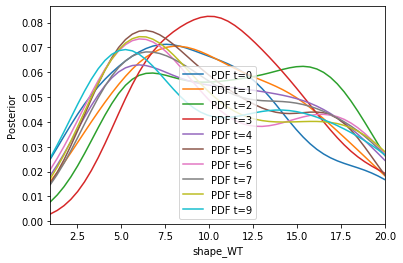

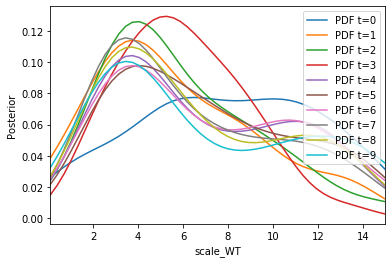

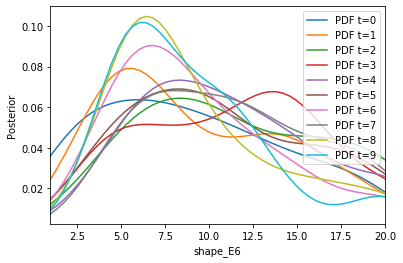

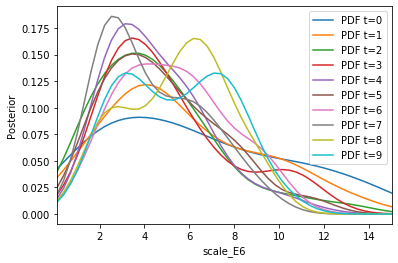

In [114]:
fig, ax = plt.subplots()
for t in range(history.max_t+1):
    df, w = history.get_distribution(m=0, t=t)
    pyabc.visualization.plot_kde_1d(
        df, w,
        xmin=shapeMin, xmax=shapeMax,
        x="shape_WT", ax=ax,
        label="PDF t={}".format(t))
ax.legend();

fig, ax = plt.subplots()
for t in range(history.max_t+1):
    df, w = history.get_distribution(m=0, t=t)
    pyabc.visualization.plot_kde_1d(
        df, w,
        xmin=scaleMin, xmax=scaleMax,
        x="scale_WT", ax=ax,
        label="PDF t={}".format(t))
ax.legend();

fig, ax = plt.subplots()
for t in range(history.max_t+1):
    df, w = history.get_distribution(m=0, t=t)
    pyabc.visualization.plot_kde_1d(
        df, w,
        xmin=shapeMin, xmax=shapeMax,
        x="shape_E6", ax=ax,
        label="PDF t={}".format(t))
ax.legend();

fig, ax = plt.subplots()
for t in range(history.max_t+1):
    df, w = history.get_distribution(m=0, t=t)
    pyabc.visualization.plot_kde_1d(
        df, w,
        xmin=scaleMin, xmax=scaleMax,
        x="scale_E6", ax=ax,
        label="PDF t={}".format(t))
ax.legend();
plt.show()

name
scale_E6     6.407941
scale_WT     4.202900
shape_E6     6.817554
shape_WT    11.809171
dtype: float64

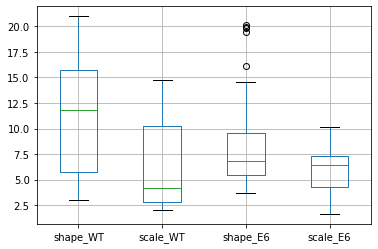

In [115]:
df.boxplot(column=['shape_WT','scale_WT','shape_E6','scale_E6'])
df.median()
plt.show()

### Compare to simulated data

In [116]:
df.head()

name,scale_E6,scale_WT,shape_E6,shape_WT
id,,,,
36832,2.895024,3.148936,12.327777,13.777087
36833,6.857632,3.547307,6.295633,12.818425
36834,7.892201,3.014792,4.498714,16.315556
36835,5.861603,10.597206,7.531849,5.963144
36836,7.717909,14.026642,4.719169,3.728700


In [117]:
myParams=pd.DataFrame({"shape_WT": [df.median()[3]],"scale_WT": [df.median()[1]], 'shape_E6': [df.median()[2]], 'scale_E6': [df.median()[0]]})
myParams

,shape_WT,scale_WT,shape_E6,scale_E6
0,11.809171,4.2029,6.817554,6.407941


In [118]:
sim=model(myParams)

Text(0, 0.5, 'Density')

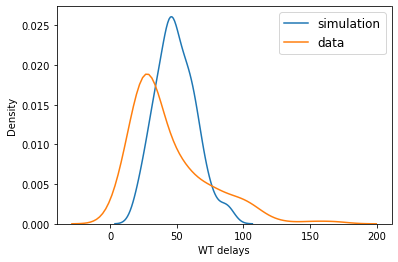

In [119]:
sns.distplot(sim['delays_WT'],hist=False,kde=True,label="simulation")
sns.distplot(data['delays_WT'],hist=False,kde=True,label="data")
plt.legend(prop={'size': 12})
plt.xlabel('WT delays')
plt.ylabel('Density') 
plt.show()

Text(0, 0.5, 'Density')

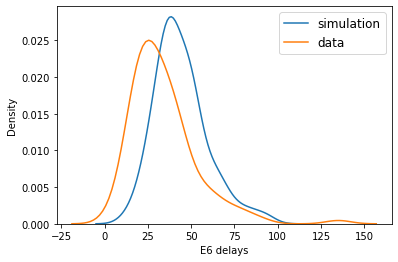

In [121]:
sns.distplot(sim['delays_E6'],hist=False,kde=True,label="simulation")
sns.distplot(data['delays_E6'],hist=False,kde=True,label="data")
plt.legend(prop={'size': 12})
plt.xlabel('E6 delays')
plt.ylabel('Density') 
plt.show()

Text(0, 0.5, 'Density')

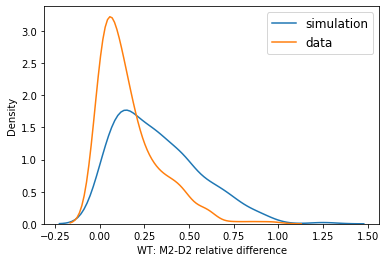

In [123]:
sns.distplot(sim['reldifs_WT'],hist=False,kde=True,label="simulation")
sns.distplot(data['reldifs_WT'],hist=False,kde=True,label="data")
plt.legend(prop={'size': 12})
plt.xlabel('WT: M2-D2 relative difference')
plt.ylabel('Density') 
plt.show()

Text(0, 0.5, 'Density')

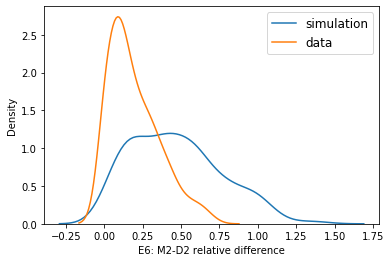

In [125]:
sns.distplot(sim['reldifs_E6'],hist=False,kde=True,label="simulation")
sns.distplot(data['reldifs_E6'],hist=False,kde=True,label="data")
plt.legend(prop={'size': 12})
plt.xlabel('E6: M2-D2 relative difference')
plt.ylabel('Density') 
plt.show()